In [1]:
!pip install rasterio --quiet


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip install tensorflow tensorflow-datasets --quiet


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)

train_ds = dataset['train']

print("Classes:", info.features['label'].names)
print("Number of images:", info.splits['train'].num_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\pc\tensorflow_datasets\eurosat\rgb\incomplete.PZ0LN8_2.0.0\eurosat-train.tfrecord*...:   0%…

Dataset eurosat downloaded and prepared to C:\Users\pc\tensorflow_datasets\eurosat\rgb\2.0.0. Subsequent calls will reuse this data.
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of images: 27000


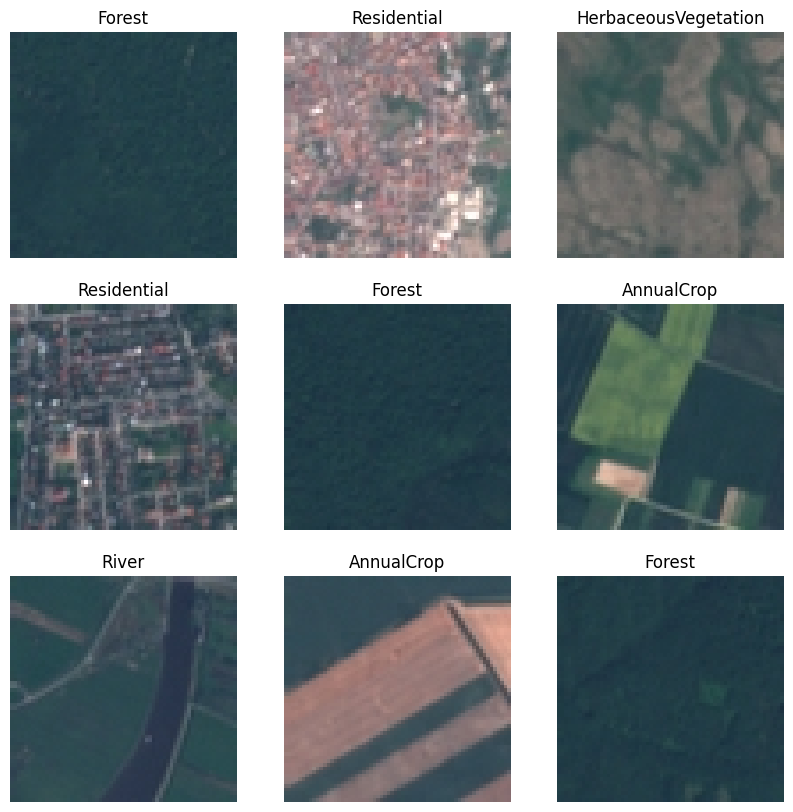

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(info.features['label'].int2str(label))
    plt.axis("off")
plt.show()


In [5]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  
    return image, label

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_ds_prepared = (
    train_ds
    .map(preprocess)
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(info.features['label'].names), activation='softmax')  # Output layer
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds_prepared, epochs=5)

C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 112s 130ms/step - accuracy: 0.4377 - loss: 1.4644
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 119s 141ms/step - accuracy: 0.7148 - loss: 0.7833
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 112s 133ms/step - accuracy: 0.7751 - loss: 0.6178
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 113s 134ms/step - accuracy: 0.8037 - loss: 0.5438
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 134s 159ms/step - accuracy: 0.8360 - loss: 0.4527


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


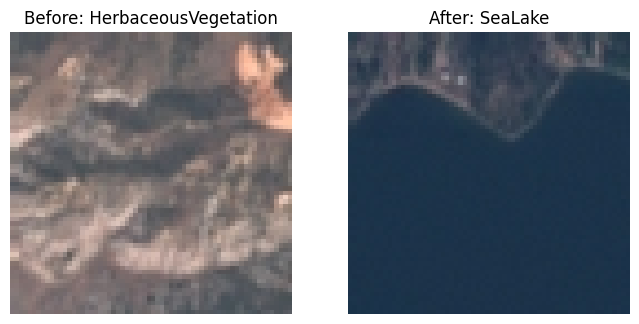

No deforestation detected.


In [7]:
import numpy as np

class_names = info.features['label'].names

samples = list(train_ds.shuffle(1000).take(2))

image1 = tf.cast(samples[0][0], tf.float32) / 255.0
image2 = tf.cast(samples[1][0], tf.float32) / 255.0

pred1 = model.predict(tf.expand_dims(image1, axis=0))
pred2 = model.predict(tf.expand_dims(image2, axis=0))

label1 = class_names[np.argmax(pred1)]
label2 = class_names[np.argmax(pred2)]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title(f"Before: {label1}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title(f"After: {label2}")
plt.axis("off")

plt.show()

if label1 == 'Forest' and label2 != 'Forest':
    print("Potential deforestation detected!")
else:
    print("No deforestation detected.")

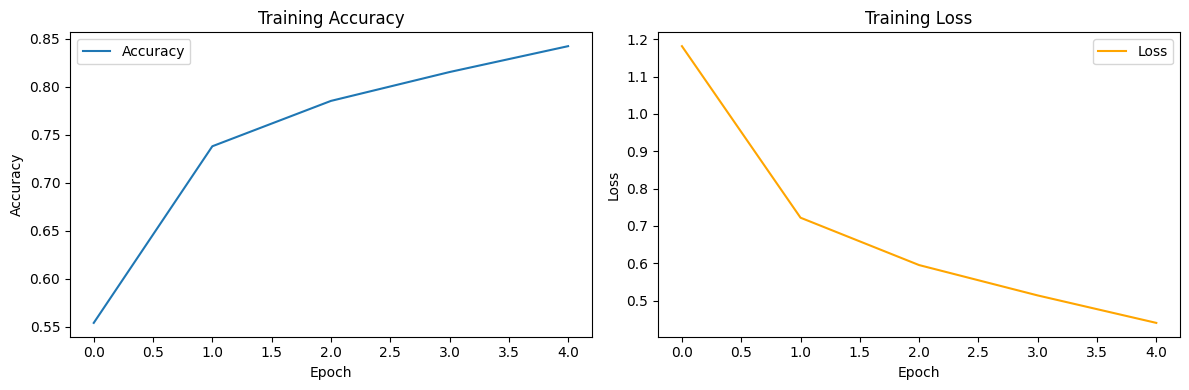

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
model.save("deforestation_cnn_model.h5")
print("Model saved as deforestation_cnn_model.h5")

Model saved as deforestation_cnn_model.h5


In [10]:
from tensorflow.keras.models import load_model
model = load_model("deforestation_cnn_model.h5")

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


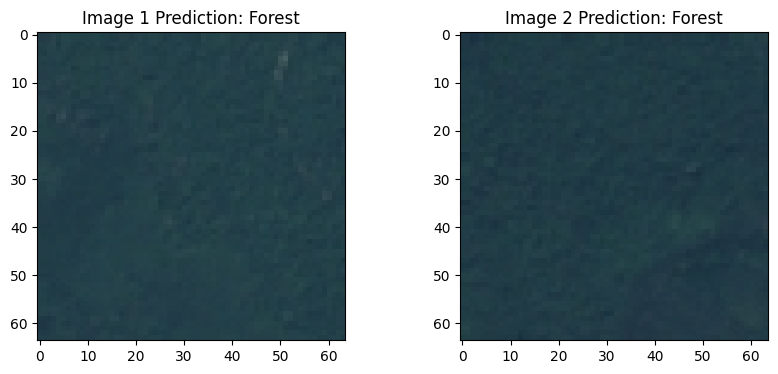

No change detected: Forest


In [11]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('deforestation_cnn_model.h5')

dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)
train_ds = dataset['train']

class_names = info.features['label'].names
print("Classes:", class_names)

data_list = list(tfds.as_numpy(train_ds))

def get_images_by_label(label_index, count=2):
    images = [img for img, lbl in data_list if lbl == label_index]
    return images[:count]

label_index = class_names.index('Forest')
images = get_images_by_label(label_index)

img1 = tf.image.resize(images[0], (64, 64)) / 255.0
img2 = tf.image.resize(images[1], (64, 64)) / 255.0

pred1 = model.predict(tf.expand_dims(img1, 0))
pred2 = model.predict(tf.expand_dims(img2, 0))

label1 = class_names[np.argmax(pred1)]
label2 = class_names[np.argmax(pred2)]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img1)
plt.title(f"Image 1 Prediction: {label1}")

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title(f"Image 2 Prediction: {label2}")

plt.show()

if label1 != label2:
    print("Deforestation (change detected):", label1, "→", label2)
else:
    print("No change detected:", label1)
